<a href="https://colab.research.google.com/github/felixxuu/ai_health/blob/main/HERMES_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Install Requirements**

In [ ]:
deepchem==2.7.1
einops==0.8.0
numpy==1.24.4
pandas==2.0.3
rdkit==2023.3.3
scikit_learn==1.3.0
scipy==1.8.1
torch==1.10.1+cu111
torch_geometric==2.0.0

**Import Requirements**

In [ ]:
import time
import os
import glob
import itertools
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
import torch
import torch.utils.data as Data
from einops import rearrange, repeat

from utils import set_seed_all, get_metrics, TruncatedExponentialLR
from process_data import getData
from similarity import get_Cosin_Similarity, get_pvalue_matrix
from drug_util import GraphDataset, collate
from HERMES.model import Initializer, HERMERS, Refiner, Consolidator

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
SEED = 1
THRESHOLD = 30
CV_RATIO = 0.9
    start_time = time.time()

    swap = False
    use_disease = True
    use_attention = False
    heads = 4

    refine_in_dim, refine_out_dim = 256, 256
    max_epoch = 3000  # 2000 or 2500
    start_update_epoch = 999
    print_interval = 200

    num_split = 5
    dataset_name = 'ALMANAC'  # ONEIL or ALMANAC
    cv_mode_ls = [1, 2, 3, 4, 5]

    lr_decay = 1 - 3e-4
    min_lr = 2e-6
    learning_rate = 1e-4
    weight_decay = 1e-2
    alpha = 1e-2

    for cv_mode, in itertools.product(cv_mode_ls):
        set_seed_all(SEED)

        drug_feature, cline_feature, synergy_data, sim_matrices, *extra = \
            load_data(dataset_name, use_disease)
        if use_disease:
            drug_sim_mat, cline_sim_mat, disease_sim_mat = sim_matrices
        else:
            drug_sim_mat, cline_sim_mat = sim_matrices
        drug_loader = Data.DataLoader(
            dataset=GraphDataset(graphs_dict=drug_feature),
            collate_fn=collate,
            batch_size=len(drug_feature),
            shuffle=False
        )
        cline_loader = Data.DataLoader(
            dataset=Data.TensorDataset(cline_feature),
            batch_size=len(cline_feature),
            shuffle=False
        )
        loaders = [drug_loader, cline_loader]
        if use_disease:
            disease_feature, interaction_pairs = extra
            disease_loader = Data.DataLoader(
                dataset=Data.TensorDataset(disease_feature),
                batch_size=len(disease_feature),
                shuffle=False
            )
            loaders.append(disease_loader)

            interaction_pairs = np.array(interaction_pairs)
            H_int_node = rearrange(
                interaction_pairs, 'n doublet -> (n doublet)')
            H_int_edge = repeat(
                np.arange(len(interaction_pairs)), 'n -> (n 2)')
            H_int = np.stack((H_int_node, H_int_edge), axis=0)
            H_int = torch.from_numpy(H_int).long().to(DEVICE)

        else:
            H_int = None

        data_cv_raw, tensor_test, label_test = data_split(
            synergy_data, SEED)

        if cv_mode == 1:
            data_cv = data_cv_raw
        elif cv_mode == 2:
            data_cv = np.unique(data_cv_raw[:, 2])
        elif cv_mode == 3:
            drugcomb = np.column_stack((data_cv_raw[:, 0], data_cv_raw[:, 1]))
            drugcomb = [tuple(sorted(pair)) for pair in drugcomb]
            data_cv = np.unique(drugcomb, axis=0)
        elif cv_mode in [4, 5]:
            data_cv = np.unique(np.concatenate(
                [data_cv_raw[:, 0], data_cv_raw[:, 1]]))
        else:
            raise NotImplementedError

        final_valid_metric = np.zeros(2)
        final_test_metric = np.zeros(2)
        final_valid_metrics, final_test_metrics = [], []
        kf = KFold(n_splits=num_split, shuffle=True, random_state=SEED)
        for idx, (train_index, valid_index) in enumerate(kf.split(data_cv), start=1):
            if cv_mode == 1:
                synergy_train, synergy_valid = data_cv[train_index], data_cv[valid_index]
            elif cv_mode == 2:
                train_name, test_name = data_cv[train_index], data_cv[valid_index]
                synergy_train, synergy_valid = [], []
                for row in data_cv_raw:
                    cline = row[2]
                    if cline in train_name:
                        synergy_train.append(row)
                    elif cline in test_name:
                        synergy_valid.append(row)
                    else:
                        raise ValueError
            elif cv_mode == 3:
                pair_train, pair_validation = data_cv[train_index], data_cv[valid_index]
                synergy_train, synergy_valid = [], []
                for row in data_cv_raw:
                    drugcomb = sorted((row[0], row[1]))
                    if any(all(x == y for x, y in zip(drugcomb, pair)) for pair in pair_train):
                        synergy_train.append(row)
                    else:
                        synergy_valid.append(row)
            elif cv_mode == 4:
                train_name, test_name = data_cv[train_index], data_cv[valid_index]
                synergy_train, synergy_valid = [], []
                for row in data_cv_raw:
                    druga, drugb = row[0], row[1]
                    if (druga in train_name) and (drugb in train_name):
                        synergy_train.append(row)
                    elif (druga in test_name) and (drugb in test_name):
                        pass
                    else:
                        synergy_valid.append(row)
            elif cv_mode == 5:
                train_name, test_name = data_cv[train_index], data_cv[valid_index]
                synergy_train, synergy_valid = [], []
                for row in data_cv_raw:
                    druga, drugb = row[0], row[1]
                    if (druga in train_name) and (drugb in train_name):
                        synergy_train.append(row)
                    elif (druga in test_name) and (drugb in test_name):
                        synergy_valid.append(row)
                    else:
                        pass
            else:
                raise NotImplementedError

            synergy_train = np.array(synergy_train)
            synergy_valid = np.array(synergy_valid)
            print(f"split {idx}")
            print("    number of train:", len(synergy_train))
            print("    number of valid:", len(synergy_valid))

            tensor_train = torch.from_numpy(synergy_train).to(DEVICE)
            tensor_valid = torch.from_numpy(synergy_valid).to(DEVICE)

            label_train = torch.from_numpy(
                np.array(synergy_train[:, 3], dtype='float32')).to(DEVICE)
            label_valid = torch.from_numpy(
                np.array(synergy_valid[:, 3], dtype='float32')).to(DEVICE)

            pos_node = synergy_train[synergy_train[:, 3] == 1, 0:3]
            num_synergy = len(pos_node)
            H_syn_node = rearrange(pos_node, 'n triplet -> (n triplet)')
            H_syn_edge = repeat(np.arange(num_synergy), 'n -> (n 3)')
            H_syn = np.stack((H_syn_node, H_syn_edge), axis=0)
            H_syn = torch.from_numpy(H_syn).long().to(DEVICE)

            set_seed_all(SEED)
            model = HERMERS(
                Initializer(
                    drug_dim=75, cline_dim=cline_feature.shape[-1], out_dim=refine_in_dim),
                Refiner(in_dim=refine_in_dim, out_dim=refine_out_dim),
                Consolidator(in_dim=refine_out_dim),
                use_disease=use_disease,
            ).to(DEVICE)
            model.initialize(num_synergy=num_synergy, H_syn=H_syn, H_int=H_int)

            ce_loss_fn = torch.nn.BCELoss()
            optimizer = torch.optim.Adam(
                model.parameters(), lr=learning_rate, weight_decay=weight_decay)
            scheduler = TruncatedExponentialLR(
                optimizer, gamma=lr_decay, min_lr=min_lr)

            best_metric = [0, 0]
            best_epoch = 0
            for epoch in range(max_epoch):
                train_label_ls, train_pred_ls = [], []
                for _ in range(1):
                    train_loss, batch_label_ls, batch_pred_ls = train(
                        tensor_train, label_train, alpha, loaders, use_disease)
                    train_label_ls.extend(batch_label_ls)
                    train_pred_ls.extend(batch_pred_ls)
                valid_label_ls, valid_pred_ls = [], []
                for _ in range(1):
                    valid_loss, batch_label_ls, batch_pred_ls = test(
                        tensor_valid, label_valid, alpha, loaders, use_disease)
                    valid_label_ls.extend(batch_label_ls)
                    valid_pred_ls.extend(batch_pred_ls)
                scheduler.step()

                if epoch >= start_update_epoch:
                    train_metric = get_metrics(train_label_ls, train_pred_ls)
                    valid_metric = get_metrics(valid_label_ls, valid_pred_ls)

                    torch.save(model.state_dict(), f'{epoch}.pth')
                    valid_auc, best_auc = valid_metric[0], best_metric[0]
                    if valid_auc > best_auc:
                        best_metric = valid_metric
                        best_epoch = epoch
                    files = glob.glob('*.pth')
                    for f in files:
                        epoch_nb = int(f.split('.')[0])
                        if epoch_nb < best_epoch:
                            os.remove(f)

                    if (epoch + 1) % print_interval == 0:
                        print(f'Epoch: {epoch:04d},',
                              f'loss_train: {train_loss:.4f},',
                              f'AUC: {train_metric[0]:.4f},',
                              f'AUPR: {train_metric[1]:.4f},',
                              )
                        print(f'Epoch: {epoch:04d},',
                              f'loss_valid: {valid_loss:.4f},',
                              f'AUC: {valid_metric[0]:.4f},',
                              f'AUPR: {valid_metric[1]:.4f},',
                              )
                        print("-" * 71)

            files = glob.glob('*.pth')
            for f in files:
                epoch_nb = int(f.split('.')[0])
                if epoch_nb > best_epoch:
                    os.remove(f)
            print('The best results on valid set,',
                  f'Epoch: {best_epoch:04d},',
                  f'AUC: {best_metric[0]:.4f},',
                  f'AUPR: {best_metric[1]:.4f},',
                  )

            model.load_state_dict(torch.load(f'{best_epoch}.pth'))
            valid_label_ls, valid_pred_ls = [], []
            for _ in range(1):
                _, batch_label_ls, batch_pred_ls = test(
                    tensor_valid, label_valid, alpha, loaders, use_disease)
                valid_label_ls.extend(batch_label_ls)
                valid_pred_ls.extend(batch_pred_ls)
            valid_metric = get_metrics(valid_label_ls, valid_pred_ls)
            test_label_ls, test_pred_ls = [], []
            for _ in range(1):
                _, batch_label_ls, batch_pred_ls = test(
                    tensor_test, label_test, alpha, loaders, use_disease)
                test_label_ls.extend(batch_label_ls)
                test_pred_ls.extend(batch_pred_ls)
            test_metric = get_metrics(test_label_ls, test_pred_ls)

            final_valid_metric += valid_metric
            final_test_metric += test_metric

            final_valid_metrics.append(valid_metric)
            final_test_metrics.append(test_metric)

        pd.DataFrame(final_valid_metrics).to_csv(f'mode_{cv_mode}.csv')

        print("-" * 71)
        for i, metrics in enumerate(final_valid_metrics, 1):
            print(f'{i}-th valid results,',
                  f'AUC: {metrics[0]:.4f},',
                  f'AUPR: {metrics[1]:.4f},',
                  )
        print("-" * 71)

        final_valid_metric /= idx
        print('Final 5-cv valid results,',
              f'AUC: {final_valid_metric[0]:.4f},',
              f'AUPR: {final_valid_metric[1]:.4f},',
              )

        final_test_metric /= idx
        print('Final 5-cv test results,',
              f'AUC: {final_test_metric[0]:.4f},',
              f'AUPR: {final_test_metric[1]:.4f},',
              )

        end_time = time.time()

        elapsed_time = end_time - start_time

        elapsed_time = int(elapsed_time)
        print(
            f"Program execution time: {elapsed_time//60} min {elapsed_time%60} sec")
        print("=" * 71)
        print()

**Function of Loading Data**
<br>prepare data feature for training models

load_data(dataset, use_disease=False)


1. getData(dataset, use_disease)	从数据集获取原始数据
2. torch.from_numpy(cline_fea).to(DEVICE)	将细胞系特征转为 PyTorch 张量，放到 GPU/CPU
3. row[3] = 1 if row[3] >= THRESHOLD else 0	二值化协同效应：≥30 为 1（有效），否则为 0
4. get_sim_mat(...)	计算相似度矩阵（药物、基因、疾病之间）

**return_data**
<br>drug_fea	         药物特征
<br>cline_fea	         细胞系特征
<br>synergy	药物协同作用数据（已二值化）
<br>sim_matrices	相似度矩阵
<br>disease_fea	疾病特征（可选）
<br>interaction	交互信息（可选）
<br> **ps:**
<br>THRESHOLD = 30 在这里被用于将连续的协同效应值转换为二分类标签（有效/无效）
<br>use_disease 参数控制是否加载疾病相关数据

In [ ]:
def load_data(dataset, use_disease=False):
    drug_fea, drug_smiles_fea, cline_fea, gene_data, synergy, *extra = \
        getData(dataset, use_disease)
    cline_fea = torch.from_numpy(cline_fea).to(DEVICE)
    if use_disease:
        disease_bert_fea, interaction = extra
        disease_fea = torch.from_numpy(disease_bert_fea).to(DEVICE)
    for row in synergy:
        row[3] = 1 if row[3] >= THRESHOLD else 0

    if use_disease:
        sim_matrices = get_sim_mat(
            drug_smiles_fea, np.array(gene_data, dtype='float32'), disease_bert_fea)
    else:
        sim_matrices = get_sim_mat(
            drug_smiles_fea, np.array(gene_data, dtype='float32'))

    ret = drug_fea, cline_fea, synergy, sim_matrices
    if use_disease:
        ret += (disease_fea, interaction)

    return ret


    start_time = time.time()

    swap = False
    use_disease = True
    use_attention = False
    heads = 4

    refine_in_dim, refine_out_dim = 256, 256
    max_epoch = 3000  # 2000 or 2500
    start_update_epoch = 999
    print_interval = 200

    num_split = 5
    dataset_name = 'ALMANAC'  # ONEIL or ALMANAC
    cv_mode_ls = [1, 2, 3, 4, 5]

    lr_decay = 1 - 3e-4
    min_lr = 2e-6
    learning_rate = 1e-4
    weight_decay = 1e-2
    alpha = 1e-2

    for cv_mode, in itertools.product(cv_mode_ls):
        set_seed_all(SEED)

        drug_feature, cline_feature, synergy_data, sim_matrices, *extra = \
            load_data(dataset_name, use_disease)
        if use_disease:
            drug_sim_mat, cline_sim_mat, disease_sim_mat = sim_matrices
        else:
            drug_sim_mat, cline_sim_mat = sim_matrices
        drug_loader = Data.DataLoader(
            dataset=GraphDataset(graphs_dict=drug_feature),
            collate_fn=collate,
            batch_size=len(drug_feature),
            shuffle=False
        )
        cline_loader = Data.DataLoader(
            dataset=Data.TensorDataset(cline_feature),
            batch_size=len(cline_feature),
            shuffle=False
        )
        loaders = [drug_loader, cline_loader]
        if use_disease:
            disease_feature, interaction_pairs = extra
            disease_loader = Data.DataLoader(
                dataset=Data.TensorDataset(disease_feature),
                batch_size=len(disease_feature),
                shuffle=False
            )
            loaders.append(disease_loader)

            interaction_pairs = np.array(interaction_pairs)
            H_int_node = rearrange(
                interaction_pairs, 'n doublet -> (n doublet)')
            H_int_edge = repeat(
                np.arange(len(interaction_pairs)), 'n -> (n 2)')
            H_int = np.stack((H_int_node, H_int_edge), axis=0)
            H_int = torch.from_numpy(H_int).long().to(DEVICE)

        else:
            H_int = None

        data_cv_raw, tensor_test, label_test = data_split(
            synergy_data, SEED)

        if cv_mode == 1:
            data_cv = data_cv_raw
        elif cv_mode == 2:
            data_cv = np.unique(data_cv_raw[:, 2])
        elif cv_mode == 3:
            drugcomb = np.column_stack((data_cv_raw[:, 0], data_cv_raw[:, 1]))
            drugcomb = [tuple(sorted(pair)) for pair in drugcomb]
            data_cv = np.unique(drugcomb, axis=0)
        elif cv_mode in [4, 5]:
            data_cv = np.unique(np.concatenate(
                [data_cv_raw[:, 0], data_cv_raw[:, 1]]))
        else:
            raise NotImplementedError

        final_valid_metric = np.zeros(2)
        final_test_metric = np.zeros(2)
        final_valid_metrics, final_test_metrics = [], []
        kf = KFold(n_splits=num_split, shuffle=True, random_state=SEED)
        for idx, (train_index, valid_index) in enumerate(kf.split(data_cv), start=1):
            if cv_mode == 1:
                synergy_train, synergy_valid = data_cv[train_index], data_cv[valid_index]
            elif cv_mode == 2:
                train_name, test_name = data_cv[train_index], data_cv[valid_index]
                synergy_train, synergy_valid = [], []
                for row in data_cv_raw:
                    cline = row[2]
                    if cline in train_name:
                        synergy_train.append(row)
                    elif cline in test_name:
                        synergy_valid.append(row)
                    else:
                        raise ValueError
            elif cv_mode == 3:
                pair_train, pair_validation = data_cv[train_index], data_cv[valid_index]
                synergy_train, synergy_valid = [], []
                for row in data_cv_raw:
                    drugcomb = sorted((row[0], row[1]))
                    if any(all(x == y for x, y in zip(drugcomb, pair)) for pair in pair_train):
                        synergy_train.append(row)
                    else:
                        synergy_valid.append(row)
            elif cv_mode == 4:
                train_name, test_name = data_cv[train_index], data_cv[valid_index]
                synergy_train, synergy_valid = [], []
                for row in data_cv_raw:
                    druga, drugb = row[0], row[1]
                    if (druga in train_name) and (drugb in train_name):
                        synergy_train.append(row)
                    elif (druga in test_name) and (drugb in test_name):
                        pass
                    else:
                        synergy_valid.append(row)
            elif cv_mode == 5:
                train_name, test_name = data_cv[train_index], data_cv[valid_index]
                synergy_train, synergy_valid = [], []
                for row in data_cv_raw:
                    druga, drugb = row[0], row[1]
                    if (druga in train_name) and (drugb in train_name):
                        synergy_train.append(row)
                    elif (druga in test_name) and (drugb in test_name):
                        synergy_valid.append(row)
                    else:
                        pass
            else:
                raise NotImplementedError

            synergy_train = np.array(synergy_train)
            synergy_valid = np.array(synergy_valid)
            print(f"split {idx}")
            print("    number of train:", len(synergy_train))
            print("    number of valid:", len(synergy_valid))

            tensor_train = torch.from_numpy(synergy_train).to(DEVICE)
            tensor_valid = torch.from_numpy(synergy_valid).to(DEVICE)

            label_train = torch.from_numpy(
                np.array(synergy_train[:, 3], dtype='float32')).to(DEVICE)
            label_valid = torch.from_numpy(
                np.array(synergy_valid[:, 3], dtype='float32')).to(DEVICE)

            pos_node = synergy_train[synergy_train[:, 3] == 1, 0:3]
            num_synergy = len(pos_node)
            H_syn_node = rearrange(pos_node, 'n triplet -> (n triplet)')
            H_syn_edge = repeat(np.arange(num_synergy), 'n -> (n 3)')
            H_syn = np.stack((H_syn_node, H_syn_edge), axis=0)
            H_syn = torch.from_numpy(H_syn).long().to(DEVICE)

            set_seed_all(SEED)
            model = HERMERS(
                Initializer(
                    drug_dim=75, cline_dim=cline_feature.shape[-1], out_dim=refine_in_dim),
                Refiner(in_dim=refine_in_dim, out_dim=refine_out_dim),
                Consolidator(in_dim=refine_out_dim),
                use_disease=use_disease,
            ).to(DEVICE)
            model.initialize(num_synergy=num_synergy, H_syn=H_syn, H_int=H_int)

            ce_loss_fn = torch.nn.BCELoss()
            optimizer = torch.optim.Adam(
                model.parameters(), lr=learning_rate, weight_decay=weight_decay)
            scheduler = TruncatedExponentialLR(
                optimizer, gamma=lr_decay, min_lr=min_lr)

            best_metric = [0, 0]
            best_epoch = 0
            for epoch in range(max_epoch):
                train_label_ls, train_pred_ls = [], []
                for _ in range(1):
                    train_loss, batch_label_ls, batch_pred_ls = train(
                        tensor_train, label_train, alpha, loaders, use_disease)
                    train_label_ls.extend(batch_label_ls)
                    train_pred_ls.extend(batch_pred_ls)
                valid_label_ls, valid_pred_ls = [], []
                for _ in range(1):
                    valid_loss, batch_label_ls, batch_pred_ls = test(
                        tensor_valid, label_valid, alpha, loaders, use_disease)
                    valid_label_ls.extend(batch_label_ls)
                    valid_pred_ls.extend(batch_pred_ls)
                scheduler.step()

                if epoch >= start_update_epoch:
                    train_metric = get_metrics(train_label_ls, train_pred_ls)
                    valid_metric = get_metrics(valid_label_ls, valid_pred_ls)

                    torch.save(model.state_dict(), f'{epoch}.pth')
                    valid_auc, best_auc = valid_metric[0], best_metric[0]
                    if valid_auc > best_auc:
                        best_metric = valid_metric
                        best_epoch = epoch
                    files = glob.glob('*.pth')
                    for f in files:
                        epoch_nb = int(f.split('.')[0])
                        if epoch_nb < best_epoch:
                            os.remove(f)

                    if (epoch + 1) % print_interval == 0:
                        print(f'Epoch: {epoch:04d},',
                              f'loss_train: {train_loss:.4f},',
                              f'AUC: {train_metric[0]:.4f},',
                              f'AUPR: {train_metric[1]:.4f},',
                              )
                        print(f'Epoch: {epoch:04d},',
                              f'loss_valid: {valid_loss:.4f},',
                              f'AUC: {valid_metric[0]:.4f},',
                              f'AUPR: {valid_metric[1]:.4f},',
                              )
                        print("-" * 71)

            files = glob.glob('*.pth')
            for f in files:
                epoch_nb = int(f.split('.')[0])
                if epoch_nb > best_epoch:
                    os.remove(f)
            print('The best results on valid set,',
                  f'Epoch: {best_epoch:04d},',
                  f'AUC: {best_metric[0]:.4f},',
                  f'AUPR: {best_metric[1]:.4f},',
                  )

            model.load_state_dict(torch.load(f'{best_epoch}.pth'))
            valid_label_ls, valid_pred_ls = [], []
            for _ in range(1):
                _, batch_label_ls, batch_pred_ls = test(
                    tensor_valid, label_valid, alpha, loaders, use_disease)
                valid_label_ls.extend(batch_label_ls)
                valid_pred_ls.extend(batch_pred_ls)
            valid_metric = get_metrics(valid_label_ls, valid_pred_ls)
            test_label_ls, test_pred_ls = [], []
            for _ in range(1):
                _, batch_label_ls, batch_pred_ls = test(
                    tensor_test, label_test, alpha, loaders, use_disease)
                test_label_ls.extend(batch_label_ls)
                test_pred_ls.extend(batch_pred_ls)
            test_metric = get_metrics(test_label_ls, test_pred_ls)

            final_valid_metric += valid_metric
            final_test_metric += test_metric

            final_valid_metrics.append(valid_metric)
            final_test_metrics.append(test_metric)

        pd.DataFrame(final_valid_metrics).to_csv(f'mode_{cv_mode}.csv')

        print("-" * 71)
        for i, metrics in enumerate(final_valid_metrics, 1):
            print(f'{i}-th valid results,',
                  f'AUC: {metrics[0]:.4f},',
                  f'AUPR: {metrics[1]:.4f},',
                  )
        print("-" * 71)

        final_valid_metric /= idx
        print('Final 5-cv valid results,',
              f'AUC: {final_valid_metric[0]:.4f},',
              f'AUPR: {final_valid_metric[1]:.4f},',
              )

        final_test_metric /= idx
        print('Final 5-cv test results,',
              f'AUC: {final_test_metric[0]:.4f},',
              f'AUPR: {final_test_metric[1]:.4f},',
              )

        end_time = time.time()

        elapsed_time = end_time - start_time

        elapsed_time = int(elapsed_time)
        print(
            f"Program execution time: {elapsed_time//60} min {elapsed_time%60} sec")
        print("=" * 71)
        print()

**Function of spliting dataframe to arrays**
<br> <br> 1	df.sample(frac=1, random_state=rd_seed)	<br> 打乱整个 DataFrame（frac=1 表示 100% 数据）
<br> <br> 2	np.array(shuffled_df)	转换为 NumPy 数组
<br> <br> 3	np.split(..., [int(ratio*len(...))])	按比例切分数组
<br> <br> 参数说明：
<br> df	输入的 DataFrame 数据
<br> ratio	训练集比例（结合 CV_RATIO=0.9，即 90% 训练，10% 测试）
<br> rd_seed	随机种子（结合 SEED=1，确保每次划分结果一致）
<br> <br> eg:假设有 100 条数据，ratio=0.9
arr_train  # 前 90 条（训练集）
arr_test   # 后 10 条（测试集）
返回值：
arr_train：训练集数组
arr_test：测试集数组

In [ ]:
def _split_dataframe_to_arrays(df, ratio, rd_seed):
    shuffled_df = df.sample(frac=1, random_state=rd_seed)
    shuffled_arr = np.array(shuffled_df)
    arr_train, arr_test = np.split(
        shuffled_arr, [int(ratio*len(shuffled_arr))])
    return arr_train, arr_test

**Function of Data Split**

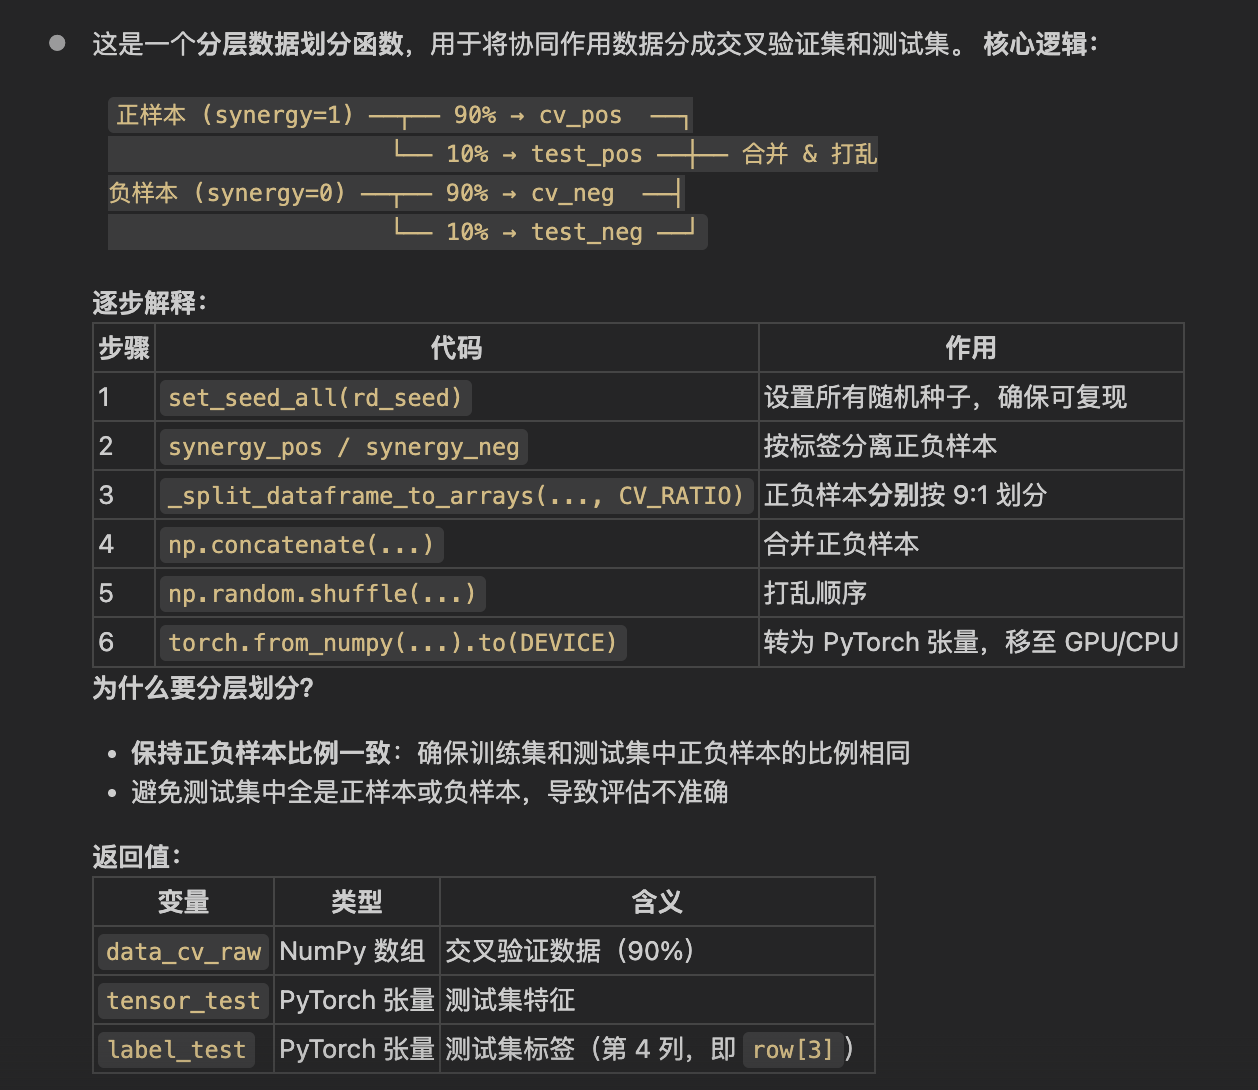

In [ ]:
def data_split(synergy, rd_seed):
    set_seed_all(rd_seed)

    synergy_pos = pd.DataFrame([i for i in synergy if i[3] == 1])
    synergy_neg = pd.DataFrame([i for i in synergy if i[3] == 0])

    synergy_cv_pos, synergy_test_pos = _split_dataframe_to_arrays(
        synergy_pos, CV_RATIO, rd_seed)
    synergy_cv_neg, synergy_test_neg = _split_dataframe_to_arrays(
        synergy_neg, CV_RATIO, rd_seed)

    data_cv_raw = np.concatenate(
        (np.array(synergy_cv_neg), np.array(synergy_cv_pos)), axis=0)
    data_test = np.concatenate(
        (np.array(synergy_test_neg), np.array(synergy_test_pos)), axis=0)

    np.random.seed(rd_seed)
    np.random.shuffle(data_cv_raw)
    np.random.seed(rd_seed)
    np.random.shuffle(data_test)
    print("    number of cross:", len(data_cv_raw))
    print("    number of test: ", len(data_test))
    tensor_test = torch.from_numpy(data_test).to(DEVICE)
    label_test = torch.from_numpy(
        np.array(data_test[:, 3], dtype='float32')).to(DEVICE)

    return data_cv_raw, tensor_test, label_test

**Function of getting similar matrix**

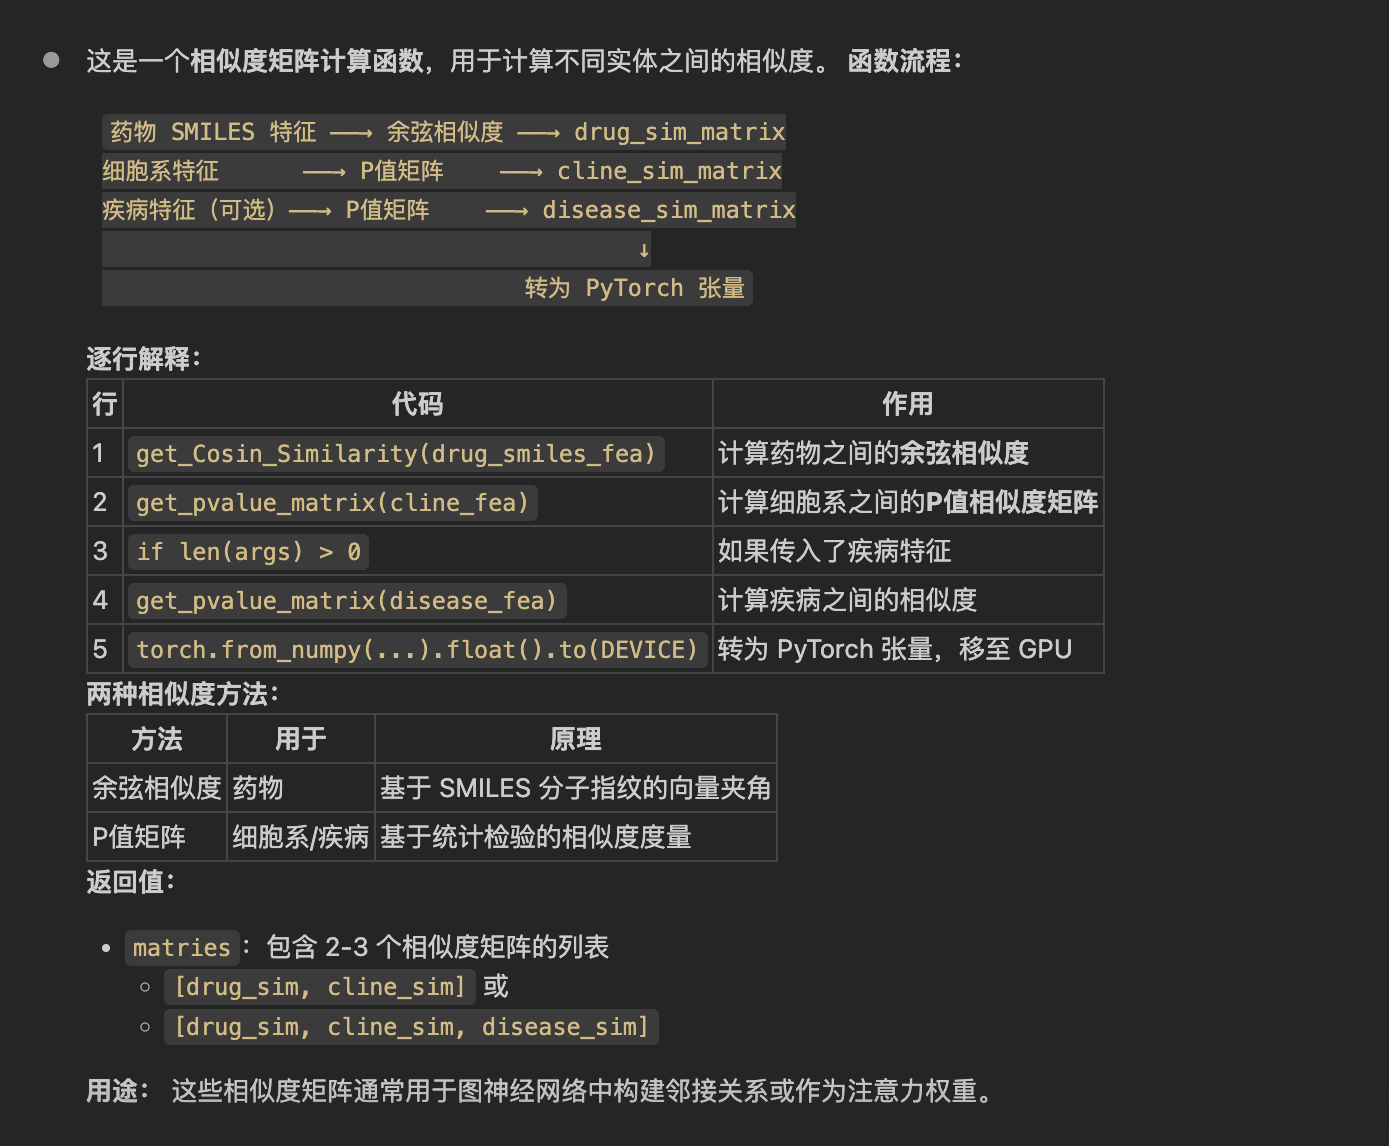

In [ ]:
def get_sim_mat(drug_smiles_fea, cline_fea, *args):
    drug_sim_matrix = get_Cosin_Similarity(drug_smiles_fea)
    cline_sim_matrix = get_pvalue_matrix(cline_fea)
    matrices_np = [drug_sim_matrix, cline_sim_matrix]
    if len(args) > 0:
        disease_fea = args[0]
        disease_sim_matrix = get_pvalue_matrix(disease_fea)
        matrices_np.append(disease_sim_matrix)
    matries = []
    for matrix in matrices_np:
        matrix = torch.from_numpy(matrix).float().to(DEVICE)
        matries.append(matrix)
    return matries


**Function of Training Model(HERMES)**

<br>输入数据 → 模型预测（主损失 + α × 辅助损失） → 计算损失 → 反向传播 → 更新参数
<br><br>1. 准备阶段（100-105行）
代码	作用
model.train()	设置模型为训练模式（启用 Dropout、BatchNorm 等）
if swap: batch_label = torch.cat(...)	如果启用数据增强，复制标签（药物A-B与B-A对称）
unbind(1)	拆分 batch：药物A ID、药物B ID、细胞系 ID、标签
optimizer.zero_grad()	清空梯度
<br><br>2. 数据加载与前向传播（110-127行）

for item in zip(*loaders):  # 同步遍历多个 DataLoader
不使用疾病特征时：

drug, (cline, ) = item
     ↓
model(...) → pred（预测值）, rec_s（重构值）
使用疾病特征时：

drug, (cline, ), (disease, ) = item
     ↓
model(...) → pred, (rec_drug, rec_cline, rec_disease)
模型输入参数：
<br>参数	含义
<br>drug.x	药物分子图的节点特征
<br>drug.edge_index	药物分子图的边索引
<br>drug.batch	批次中各节点属于哪个药物
<br>cline	细胞系特征
<br>druga_id, drugb_id, cline_id	当前 batch 的 ID 索引
<br>disease（可选）	疾病特征
<br><br>3. 损失计算（129-135行） 双重损失设计：
损失类型	公式	作用
主损失	ce_loss(pred, batch_label)	预测协同效应的分类损失
辅助损失	ce_loss(rec_drug, drug_sim_mat) + ce_loss(rec_cline, cline_sim_mat)	重构相似度矩阵的损失
总损失：

loss = loss_target + alpha * loss_aux
alpha 控制辅助损失的权重
辅助损失的作用：自监督学习，让模型学习到好的药物/细胞系表示
<br><br>4. 反向传播与参数更新（137-140行）
代码	作用
loss.backward()	计算梯度
optimizer.step()	更新模型参数
<br><br>5. 记录结果（142-144行）

loss_train += loss.item()           # 累加损失
batch_label_ls += batch_label...    # 收集真实标签
batch_pred_ls += pred...            # 收集预测值
返回值：
变量	含义
loss_train	总训练损失
batch_label_ls	所有真实标签（用于计算指标）
batch_pred_ls	所有预测值（用于计算 AUC 等）
<br><br>核心设计亮点：
多任务学习：主任务（协同预测）+ 辅助任务（相似度重构）
图神经网络：使用 edge_index 处理药物分子结构
灵活扩展：通过 use_disease 参数支持是否加入疾病信息

In [ ]:
def train(batch_tensor, batch_label, alpha, loaders, use_disease=False):
    model.train()
    if swap:
        batch_label = torch.cat((batch_label, batch_label), dim=0)

    druga_id, drugb_id, cline_id, _ = batch_tensor.unbind(1)

    optimizer.zero_grad()
    loss_train = 0
    batch_label_ls, batch_pred_ls = [], []
    for item in zip(*loaders):
        if use_disease:
            drug, (cline, ), (disease, ) = item
            pred, rec_s = model(
                drug.x, drug.edge_index, drug.batch,
                cline,
                druga_id, drugb_id, cline_id,
                disease,
            )
            rec_drug, rec_cline, rec_disease = rec_s
        else:
            drug, (cline, ) = item
            pred, rec_s = model(
                drug.x, drug.edge_index, drug.batch,
                cline,
                druga_id, drugb_id, cline_id,
            )
            rec_drug, rec_cline = rec_s

        loss_target = ce_loss_fn(pred, batch_label)
        loss_aux = ce_loss_fn(rec_drug, drug_sim_mat) + \
            ce_loss_fn(rec_cline, cline_sim_mat)
        if use_disease:
            loss_aux += ce_loss_fn(rec_disease, disease_sim_mat)

        loss = loss_target + alpha * loss_aux

        loss.backward()

        optimizer.step()

        loss_train += loss.item()
        batch_label_ls += batch_label.cpu().detach().numpy().tolist()
        batch_pred_ls += pred.cpu().detach().numpy().tolist()

    return loss_train, batch_label_ls, batch_pred_ls


**Function to test**


<br>1. 设置评估模式（148-149行）

model.eval()
关闭 Dropout（不再随机丢弃神经元）
BatchNorm 使用训练时的统计量而非当前 batch
<br>2. 禁用梯度计算（152行）

with torch.no_grad():
不计算梯度，节省内存和计算时间
测试时只需前向传播，不需要反向传播
<br>3. 前向传播（153-165行） 与 train 完全相同的模型调用：

输入 → model() → batch_pred（预测值）, rec_s（重构值）
<br>4. 损失计算（167-173行）

loss = loss_target + alpha * loss_aux
虽然测试时不更新参数，但仍计算损失用于：
监控模型在验证集上的表现
判断是否过拟合（训练损失下降但验证损失上升）
<br>5. 返回结果（175-177行）

batch_label = batch_label.cpu().detach().numpy()
batch_pred = batch_pred.cpu().detach().numpy()
return loss.item(), batch_label, batch_pred

In [ ]:
def test(batch_tensor, batch_label, alpha, loaders, use_disease=False):
    model.eval()

    druga_id, drugb_id, cline_id, _ = batch_tensor.unbind(1)
    with torch.no_grad():
        for item in zip(*loaders):
            if use_disease:
                drug, (cline,), (disease,) = item
                batch_pred, rec_s = model(
                    drug.x, drug.edge_index, drug.batch, cline,
                    druga_id, drugb_id, cline_id, disease)
                rec_drug, rec_cline, rec_disease = rec_s
            else:
                drug, (cline, ) = item
                batch_pred, rec_s = model(
                    drug.x, drug.edge_index, drug.batch, cline,
                    druga_id, drugb_id, cline_id)
                rec_drug, rec_cline = rec_s

        loss_target = ce_loss_fn(batch_pred, batch_label)

        loss_aux = ce_loss_fn(rec_drug, drug_sim_mat) + \
            ce_loss_fn(rec_cline, cline_sim_mat)
        if use_disease:
            loss_aux += ce_loss_fn(rec_disease, disease_sim_mat)
        loss = loss_target + alpha * loss_aux

        batch_label = batch_label.cpu().detach().numpy()
        batch_pred = batch_pred.cpu().detach().numpy()
        return loss.item(), batch_label, batch_pred

1.超参数配置（180-201行）
swap = False：是否启用药物对称增强（A-B 与 B-A）
use_disease = True：是否使用疾病特征
use_attention = False：是否使用注意力机制
heads = 4：注意力头数
max_epoch = 3000：最大训练轮数
start_update_epoch = 999：第 999 轮后才开始保存模型
num_split = 5：5 折交叉验证
dataset_name = 'ALMANAC'：数据集名称
cv_mode_ls = [1,2,3,4,5]：5 种交叉验证模式
learning_rate = 1e-4：学习率
weight_decay = 1e-2：L2 正则化
alpha = 1e-2：辅助损失权重
<br><br>2. 数据加载与预处理（203-244行）
首先调用 load_data() 获取药物/细胞系/疾病特征和相似度矩阵，然后创建三个 DataLoader（drug_loader, cline_loader, disease_loader），最后构建超图索引 H_int（药物-疾病交互）。 超图构建（H_int）：

H_int_node = rearrange(interaction_pairs, 'n doublet -> (n doublet)')
H_int_edge = repeat(np.arange(len(interaction_pairs)), 'n -> (n 2)')
将药物-疾病交互对转换为超图的节点-超边索引格式。
<br><br>3. 五种交叉验证模式（246-302行）
这是代码的核心亮点，测试模型在不同泛化场景下的表现：
cv_mode = 1：随机划分样本，测试基础泛化能力
cv_mode = 2：按细胞系划分，测试能否泛化到新细胞系
cv_mode = 3：按药物组合划分，测试能否预测新药物组合
cv_mode = 4：按单药划分（混合），训练集药物与测试集药物有交集
cv_mode = 5：按单药划分（严格），测试集药物完全未见过
模式 5 最严格：测试集中的两个药物在训练时都没出现过。
<br><br>4. K 折交叉验证循环（260-390行）
对于每一折：
根据 cv_mode 划分训练集和验证集
构建超图 H_syn（协同作用正样本的三元组）
初始化 HERMERS 模型
进行 max_epoch 轮训练，每轮调用 train() 和 test()
保存验证集上 AUC 最高的模型，删除其他模型
加载最佳模型，在测试集上评估
超图 H_syn 构建（319-324行）：

pos_node = synergy_train[synergy_train[:, 3] == 1, 0:3]  # 正样本的 (drugA, drugB, cline)
H_syn_node = rearrange(pos_node, 'n triplet -> (n triplet)')
H_syn_edge = repeat(np.arange(num_synergy), 'n -> (n 3)')
每个协同作用三元组（药物A、药物B、细胞系）构成一条超边。
<br><br>5. 模型初始化（326-341行）

model = HERMERS(
    Initializer(drug_dim=75, cline_dim=..., out_dim=256),  # 特征初始化
    Refiner(in_dim=256, out_dim=256),                       # 特征精炼
    Consolidator(in_dim=256),                               # 特征整合/预测
    use_disease=True,
)
model.initialize(num_synergy=num_synergy, H_syn=H_syn, H_int=H_int)
模型架构是：Initializer（原始特征）→ Refiner（超图传播）→ Consolidator（特征融合）→ 预测
<br><br>6. 训练循环与早停（347-390行）

for epoch in range(max_epoch):
    train(...)  # 训练
    test(...)   # 验证
    
    if epoch >= start_update_epoch:  # 第 999 轮后
        if valid_auc > best_auc:
            best_metric = valid_metric
            best_epoch = epoch
        # 删除非最佳模型，节省空间
模型保存策略：每轮保存 {epoch}.pth，只保留验证集 AUC 最高的模型，删除其他模型文件。
<br><br>7. 最终评估与结果输出（392-458行）
加载最佳模型，在验证集和测试集上评估，累加 5 折结果，最后输出平均的 AUC 和 AUPR。

final_valid_metric /= 5
final_test_metric /= 5
整体流程

for cv_mode in [1,2,3,4,5]:
    for fold in 5-Fold:
        for epoch in range(3000):
            train() → test() → save best model
        load best model → evaluate on test set
    output: AUC, AUPR (avg of 5 folds)
总结： 这是一个完整的药物协同作用预测实验框架，通过 5 种不同的交叉验证模式全面评估模型的泛化能力。


In [ ]:
if __name__ == '__main__':
    start_time = time.time()

    swap = False
    use_disease = True
    use_attention = False
    heads = 4

    refine_in_dim, refine_out_dim = 256, 256
    max_epoch = 3000  # 2000 or 2500
    start_update_epoch = 999
    print_interval = 200

    num_split = 5
    dataset_name = 'ALMANAC'  # ONEIL or ALMANAC
    cv_mode_ls = [1, 2, 3, 4, 5]

    lr_decay = 1 - 3e-4
    min_lr = 2e-6
    learning_rate = 1e-4
    weight_decay = 1e-2
    alpha = 1e-2

    for cv_mode, in itertools.product(cv_mode_ls):
        set_seed_all(SEED)

        drug_feature, cline_feature, synergy_data, sim_matrices, *extra = \
            load_data(dataset_name, use_disease)
        if use_disease:
            drug_sim_mat, cline_sim_mat, disease_sim_mat = sim_matrices
        else:
            drug_sim_mat, cline_sim_mat = sim_matrices
        drug_loader = Data.DataLoader(
            dataset=GraphDataset(graphs_dict=drug_feature),
            collate_fn=collate,
            batch_size=len(drug_feature),
            shuffle=False
        )
        cline_loader = Data.DataLoader(
            dataset=Data.TensorDataset(cline_feature),
            batch_size=len(cline_feature),
            shuffle=False
        )
        loaders = [drug_loader, cline_loader]
        if use_disease:
            disease_feature, interaction_pairs = extra
            disease_loader = Data.DataLoader(
                dataset=Data.TensorDataset(disease_feature),
                batch_size=len(disease_feature),
                shuffle=False
            )
            loaders.append(disease_loader)

            interaction_pairs = np.array(interaction_pairs)
            H_int_node = rearrange(
                interaction_pairs, 'n doublet -> (n doublet)')
            H_int_edge = repeat(
                np.arange(len(interaction_pairs)), 'n -> (n 2)')
            H_int = np.stack((H_int_node, H_int_edge), axis=0)
            H_int = torch.from_numpy(H_int).long().to(DEVICE)

        else:
            H_int = None

        data_cv_raw, tensor_test, label_test = data_split(
            synergy_data, SEED)

        if cv_mode == 1:
            data_cv = data_cv_raw
        elif cv_mode == 2:
            data_cv = np.unique(data_cv_raw[:, 2])
        elif cv_mode == 3:
            drugcomb = np.column_stack((data_cv_raw[:, 0], data_cv_raw[:, 1]))
            drugcomb = [tuple(sorted(pair)) for pair in drugcomb]
            data_cv = np.unique(drugcomb, axis=0)
        elif cv_mode in [4, 5]:
            data_cv = np.unique(np.concatenate(
                [data_cv_raw[:, 0], data_cv_raw[:, 1]]))
        else:
            raise NotImplementedError

        final_valid_metric = np.zeros(2)
        final_test_metric = np.zeros(2)
        final_valid_metrics, final_test_metrics = [], []
        kf = KFold(n_splits=num_split, shuffle=True, random_state=SEED)
        for idx, (train_index, valid_index) in enumerate(kf.split(data_cv), start=1):
            if cv_mode == 1:
                synergy_train, synergy_valid = data_cv[train_index], data_cv[valid_index]
            elif cv_mode == 2:
                train_name, test_name = data_cv[train_index], data_cv[valid_index]
                synergy_train, synergy_valid = [], []
                for row in data_cv_raw:
                    cline = row[2]
                    if cline in train_name:
                        synergy_train.append(row)
                    elif cline in test_name:
                        synergy_valid.append(row)
                    else:
                        raise ValueError
            elif cv_mode == 3:
                pair_train, pair_validation = data_cv[train_index], data_cv[valid_index]
                synergy_train, synergy_valid = [], []
                for row in data_cv_raw:
                    drugcomb = sorted((row[0], row[1]))
                    if any(all(x == y for x, y in zip(drugcomb, pair)) for pair in pair_train):
                        synergy_train.append(row)
                    else:
                        synergy_valid.append(row)
            elif cv_mode == 4:
                train_name, test_name = data_cv[train_index], data_cv[valid_index]
                synergy_train, synergy_valid = [], []
                for row in data_cv_raw:
                    druga, drugb = row[0], row[1]
                    if (druga in train_name) and (drugb in train_name):
                        synergy_train.append(row)
                    elif (druga in test_name) and (drugb in test_name):
                        pass
                    else:
                        synergy_valid.append(row)
            elif cv_mode == 5:
                train_name, test_name = data_cv[train_index], data_cv[valid_index]
                synergy_train, synergy_valid = [], []
                for row in data_cv_raw:
                    druga, drugb = row[0], row[1]
                    if (druga in train_name) and (drugb in train_name):
                        synergy_train.append(row)
                    elif (druga in test_name) and (drugb in test_name):
                        synergy_valid.append(row)
                    else:
                        pass
            else:
                raise NotImplementedError

            synergy_train = np.array(synergy_train)
            synergy_valid = np.array(synergy_valid)
            print(f"split {idx}")
            print("    number of train:", len(synergy_train))
            print("    number of valid:", len(synergy_valid))

            tensor_train = torch.from_numpy(synergy_train).to(DEVICE)
            tensor_valid = torch.from_numpy(synergy_valid).to(DEVICE)

            label_train = torch.from_numpy(
                np.array(synergy_train[:, 3], dtype='float32')).to(DEVICE)
            label_valid = torch.from_numpy(
                np.array(synergy_valid[:, 3], dtype='float32')).to(DEVICE)

            pos_node = synergy_train[synergy_train[:, 3] == 1, 0:3]
            num_synergy = len(pos_node)
            H_syn_node = rearrange(pos_node, 'n triplet -> (n triplet)')
            H_syn_edge = repeat(np.arange(num_synergy), 'n -> (n 3)')
            H_syn = np.stack((H_syn_node, H_syn_edge), axis=0)
            H_syn = torch.from_numpy(H_syn).long().to(DEVICE)

            set_seed_all(SEED)
            model = HERMERS(
                Initializer(
                    drug_dim=75, cline_dim=cline_feature.shape[-1], out_dim=refine_in_dim),
                Refiner(in_dim=refine_in_dim, out_dim=refine_out_dim),
                Consolidator(in_dim=refine_out_dim),
                use_disease=use_disease,
            ).to(DEVICE)
            model.initialize(num_synergy=num_synergy, H_syn=H_syn, H_int=H_int)

            ce_loss_fn = torch.nn.BCELoss()
            optimizer = torch.optim.Adam(
                model.parameters(), lr=learning_rate, weight_decay=weight_decay)
            scheduler = TruncatedExponentialLR(
                optimizer, gamma=lr_decay, min_lr=min_lr)

            best_metric = [0, 0]
            best_epoch = 0
            for epoch in range(max_epoch):
                train_label_ls, train_pred_ls = [], []
                for _ in range(1):
                    train_loss, batch_label_ls, batch_pred_ls = train(
                        tensor_train, label_train, alpha, loaders, use_disease)
                    train_label_ls.extend(batch_label_ls)
                    train_pred_ls.extend(batch_pred_ls)
                valid_label_ls, valid_pred_ls = [], []
                for _ in range(1):
                    valid_loss, batch_label_ls, batch_pred_ls = test(
                        tensor_valid, label_valid, alpha, loaders, use_disease)
                    valid_label_ls.extend(batch_label_ls)
                    valid_pred_ls.extend(batch_pred_ls)
                scheduler.step()

                if epoch >= start_update_epoch:
                    train_metric = get_metrics(train_label_ls, train_pred_ls)
                    valid_metric = get_metrics(valid_label_ls, valid_pred_ls)

                    torch.save(model.state_dict(), f'{epoch}.pth')
                    valid_auc, best_auc = valid_metric[0], best_metric[0]
                    if valid_auc > best_auc:
                        best_metric = valid_metric
                        best_epoch = epoch
                    files = glob.glob('*.pth')
                    for f in files:
                        epoch_nb = int(f.split('.')[0])
                        if epoch_nb < best_epoch:
                            os.remove(f)

                    if (epoch + 1) % print_interval == 0:
                        print(f'Epoch: {epoch:04d},',
                              f'loss_train: {train_loss:.4f},',
                              f'AUC: {train_metric[0]:.4f},',
                              f'AUPR: {train_metric[1]:.4f},',
                              )
                        print(f'Epoch: {epoch:04d},',
                              f'loss_valid: {valid_loss:.4f},',
                              f'AUC: {valid_metric[0]:.4f},',
                              f'AUPR: {valid_metric[1]:.4f},',
                              )
                        print("-" * 71)

            files = glob.glob('*.pth')
            for f in files:
                epoch_nb = int(f.split('.')[0])
                if epoch_nb > best_epoch:
                    os.remove(f)
            print('The best results on valid set,',
                  f'Epoch: {best_epoch:04d},',
                  f'AUC: {best_metric[0]:.4f},',
                  f'AUPR: {best_metric[1]:.4f},',
                  )

            model.load_state_dict(torch.load(f'{best_epoch}.pth'))
            valid_label_ls, valid_pred_ls = [], []
            for _ in range(1):
                _, batch_label_ls, batch_pred_ls = test(
                    tensor_valid, label_valid, alpha, loaders, use_disease)
                valid_label_ls.extend(batch_label_ls)
                valid_pred_ls.extend(batch_pred_ls)
            valid_metric = get_metrics(valid_label_ls, valid_pred_ls)
            test_label_ls, test_pred_ls = [], []
            for _ in range(1):
                _, batch_label_ls, batch_pred_ls = test(
                    tensor_test, label_test, alpha, loaders, use_disease)
                test_label_ls.extend(batch_label_ls)
                test_pred_ls.extend(batch_pred_ls)
            test_metric = get_metrics(test_label_ls, test_pred_ls)

            final_valid_metric += valid_metric
            final_test_metric += test_metric

            final_valid_metrics.append(valid_metric)
            final_test_metrics.append(test_metric)

        pd.DataFrame(final_valid_metrics).to_csv(f'mode_{cv_mode}.csv')

        print("-" * 71)
        for i, metrics in enumerate(final_valid_metrics, 1):
            print(f'{i}-th valid results,',
                  f'AUC: {metrics[0]:.4f},',
                  f'AUPR: {metrics[1]:.4f},',
                  )
        print("-" * 71)

        final_valid_metric /= idx
        print('Final 5-cv valid results,',
              f'AUC: {final_valid_metric[0]:.4f},',
              f'AUPR: {final_valid_metric[1]:.4f},',
              )

        final_test_metric /= idx
        print('Final 5-cv test results,',
              f'AUC: {final_test_metric[0]:.4f},',
              f'AUPR: {final_test_metric[1]:.4f},',
              )

        end_time = time.time()

        elapsed_time = end_time - start_time

        elapsed_time = int(elapsed_time)
        print(
            f"Program execution time: {elapsed_time//60} min {elapsed_time%60} sec")
        print("=" * 71)
        print()